In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

def preprocess_image(path, img_size=(128, 128)):
    img = Image.open(path).convert("RGB").resize(img_size)
    img_array = np.array(img) / 255.0
    return tf.expand_dims(img_array, axis=0)

def create_mask_table(pred_mask, threshold=0.5):
    # Apply threshold for table prediction (pixel-wise thresholding)
    segmented_mask = tf.cast(pred_mask > threshold, tf.int32)  # 1 if > threshold, else 0
    return segmented_mask

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Predicted Table Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()



In [3]:
model = load_model('stored_model/3/model_googlenet_new2.keras')


In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_191 (Conv2D)            (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 63, 63, 32)  96          ['conv2d_191[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [6]:
image_path = 'testing_images/img3.jpg'
input_image = preprocess_image(image_path)



In [9]:
predictions = model.predict(input_image)
#table_mask = tf.squeeze(create_mask_table(predictions[0]), axis=0)


1/1 [==============================] - 4s 4s/step


In [11]:
print("Table pred min/max:", tf.reduce_min(predictions[0]), tf.reduce_max(predictions[0]))
print("Column pred min/max:", tf.reduce_min(predictions[1]), tf.reduce_max(predictions[1]))

Table pred min/max: tf.Tensor(2.534809e-08, shape=(), dtype=float32) tf.Tensor(0.5750789, shape=(), dtype=float32)
Column pred min/max: tf.Tensor(5.2950075e-09, shape=(), dtype=float32) tf.Tensor(0.54251206, shape=(), dtype=float32)


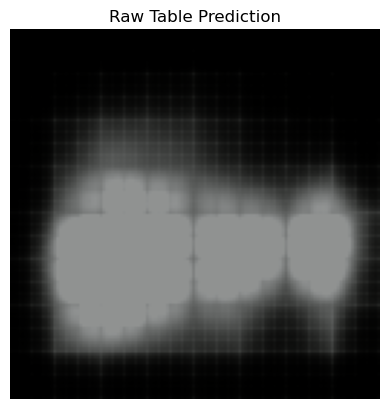

In [13]:
plt.imshow(tf.squeeze(predictions[0]), cmap='gray')
plt.title("Raw Table Prediction")
plt.axis('off')
plt.show()


In [15]:
table_mask = tf.squeeze(create_mask_table(predictions[0], threshold=0.4), axis=0)



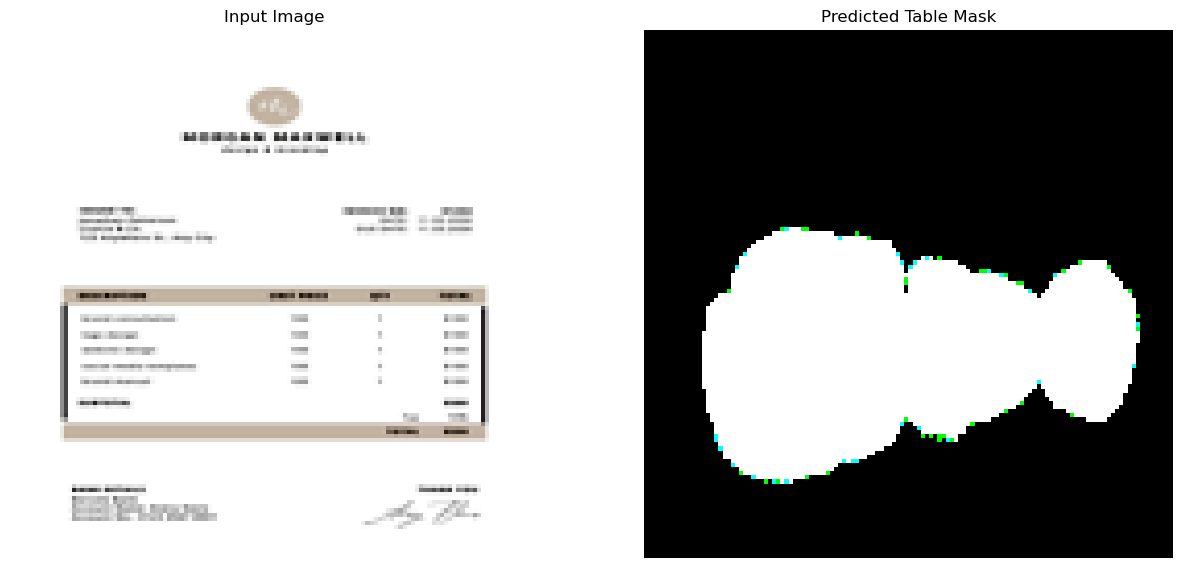

In [17]:

display([tf.squeeze(input_image), table_mask])

In [19]:
mask_np = table_mask.numpy().astype(np.uint8)


In [137]:
import cv2

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 2))
cleaned_mask = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)

# Close gaps in the blob
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)


In [139]:
# If your mask is like (H, W, 1), remove the last dimension
if len(cleaned_mask.shape) == 3:
    cleaned_mask = cleaned_mask[:, :, 0]

# Ensure it is binary 0 and 255, not just 0 and 1
cleaned_mask = (cleaned_mask * 255).astype(np.uint8)

In [141]:
kernel = np.ones((1, 7), np.uint8)
dilated_mask = cv2.dilate(cleaned_mask, kernel, iterations=1)

In [143]:
contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest = max(contours, key=cv2.contourArea)

# Get bounding box
x, y, w, h = cv2.boundingRect(largest)

In [145]:
print(x,y,w,h)

11 51 112 60


In [147]:
from PIL import Image
import numpy as np

original = Image.open('testing_images/img3.jpg')
original = np.array(original)

In [149]:
scale_x = original.shape[1] / 128
scale_y = original.shape[0] / 128

x_f = int(x * scale_x)
y_f = int(y * scale_y)
w_f = int(w * scale_x)
h_f = int(h * scale_y)


In [151]:
input_image.shape

TensorShape([1, 128, 128, 3])

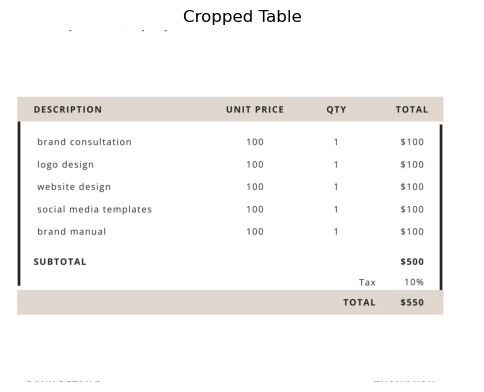

In [153]:
img=tf.squeeze(input_image,axis=0)
cropped_table = original[y_f:y_f+h_f, x_f:x_f+w_f]
plt.figure(figsize=(6, 6))
plt.title("Cropped Table")
plt.imshow(tf.keras.preprocessing.image.array_to_img(cropped_table))
plt.axis("off")
plt.show()

In [66]:
%pip  install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [155]:
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

# Convert to grayscale
gray = cv2.cvtColor(cropped_table, cv2.COLOR_BGR2GRAY)

# Apply sharpening kernel
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened = cv2.filter2D(gray, -1, kernel)

# Threshold the image to clean edges
_, thresh = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# OCR on thresholded image
text = pytesseract.image_to_string(thresh)
print("Extracted Text:\n", text)

Extracted Text:
 DESCRIPTION

brand consultation
logo design

website design

social media templates

brand manual

SUBTOTAL

UNIT PRICE

100

100

100

100

100

QTy

Tax

TOTAL

TOTAL

$100
$100
$100
$100

$100

$500
10%

$550



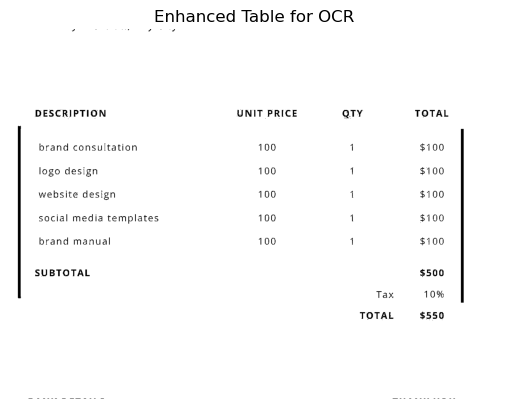

In [157]:
# Optional: show image before OCR
plt.imshow(thresh, cmap='gray')
plt.title("Enhanced Table for OCR")
plt.axis('off')
plt.show()

In [163]:
import os
os.makedirs('output', exist_ok=True)
cv2.imwrite('output/cropped1.png',thresh)

True

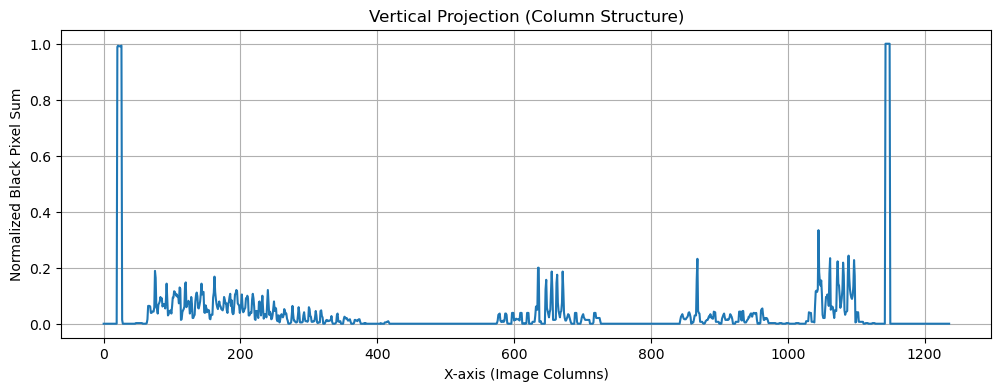

In [181]:
vertical_sum = np.sum(thresh == 0, axis=0)  # 0 means black pixels after inversion

# Normalize for visualization
normalized = vertical_sum / np.max(vertical_sum)

# Plot the projection profile
plt.figure(figsize=(12, 4))
plt.plot(normalized)
plt.title('Vertical Projection (Column Structure)')
plt.xlabel('X-axis (Image Columns)')
plt.ylabel('Normalized Black Pixel Sum')
plt.grid(True)
plt.show()

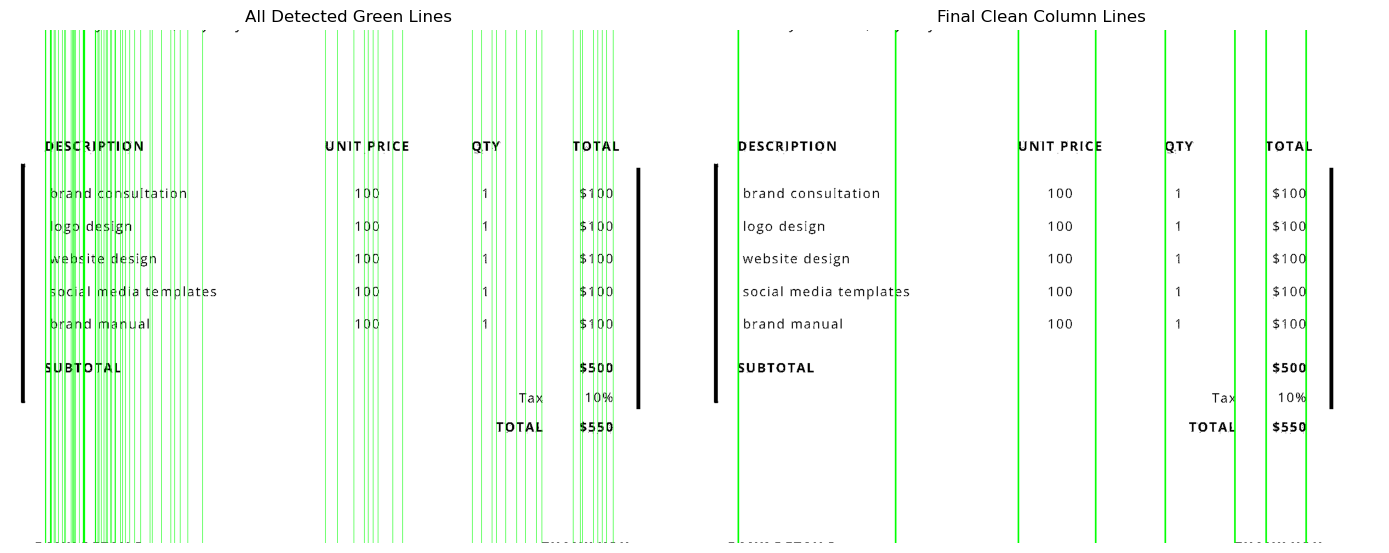

In [169]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('output/cropped1.png')
output_all = image.copy()
output_clean = image.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, image.shape[0] // 20))
dilated = cv2.dilate(binary, kernel, iterations=1)

contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

column_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 10 and h > 20:
        column_boxes.append((x, y, w, h))

x_positions = sorted([x for (x, y, w, h) in column_boxes])

# Draw ALL detected green lines
for x in x_positions:
    cv2.line(output_all, (x, 0), (x, image.shape[0]), (0, 255, 0), 1)

# Clustering
gap_threshold = 50
clusters = []
current_cluster = []

for x in x_positions:
    if not current_cluster:
        current_cluster.append(x)
    elif abs(x - current_cluster[-1]) <= gap_threshold:
        current_cluster.append(x)
    else:
        clusters.append(current_cluster)
        current_cluster = [x]
if current_cluster:
    clusters.append(current_cluster)

# Draw only the start & end of each cluster
final_lines = []
for cluster in clusters:
    if len(cluster) >= 2:
        final_lines.append(cluster[0])
        final_lines.append(cluster[-1])
    else:
        final_lines.append(cluster[0])

for x in final_lines:
    cv2.line(output_clean, (x, 0), (x, image.shape[0]), (0, 255, 0), 2)

# Show both images
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(output_all, cv2.COLOR_BGR2RGB))
plt.title("All Detected Green Lines")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_clean, cv2.COLOR_BGR2RGB))
plt.title("Final Clean Column Lines")
plt.axis('off')

plt.tight_layout()
plt.show()


In [199]:
inal_lines = sorted(final_lines)
columns = []
padding = 10
for i in range(len(final_lines) - 1):
    x1 = final_lines[i]
    x2 = final_lines[i + 1]
    x1_padded = max(0, x1 - padding)
    x2_padded = min(image.shape[1], x2 + padding)
    column_crop = image[:, x1_padded:x2_padded]
    columns.append(column_crop)


In [201]:
# OCR each column
ocr_text_per_column = []
for col in columns:
    col_gray = cv2.cvtColor(col, cv2.COLOR_BGR2GRAY)
    _, col_thresh = cv2.threshold(col_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    text = pytesseract.image_to_string(col_thresh, config='--psm 6')
    lines = [line.strip() for line in text.split('\n') if line.strip()]
    ocr_text_per_column.append(lines)

In [203]:
from itertools import zip_longest
import csv
filtered_ocr = []

for col in ocr_text_per_column:
    flat_text = ' '.join(col)
    if len(flat_text.strip()) > 3:  # Only keep if meaningful text exists
        filtered_ocr.append(col)

ocr_text_per_column = filtered_ocr
rows = list(zip_longest(*ocr_text_per_column, fillvalue=''))


In [205]:
with open('output/column_extraction_1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(rows)

In [207]:
import pandas as pd

df = pd.read_csv('output/column_extraction_1.csv')
print(df.head())

             DESCRIPTION    l  UNIT PRICE  -E C QTY    T TOTAL
0     brand consultation  ces       100.0   NaN   4    x  $100
1            logo design  NaN       100.0   NaN   1    L  $100
2         website design  NaN       100.0   NaN   1  NaN  $100
3  social media template  NaN       100.0   NaN   1  NaN  $100
4           brand manual  NaN       100.0   NaN   4  NaN  $100


In [209]:
# df is your extracted DataFrame
threshold = 0.5  # drop columns with more than 50% NaNs

null_columns = df.columns[df.isnull().mean() > threshold]
df_cleaned = df.drop(columns=null_columns)

In [211]:
df_cleaned.head()

,DESCRIPTION,UNIT PRICE,QTY,TOTAL
0,brand consultation,100.0,4,$100
1,logo design,100.0,1,$100
2,website design,100.0,1,$100
3,social media template,100.0,1,$100
4,brand manual,100.0,4,$100
